# Report

We decided to go with an Unet design since it's good for detecting features which span across the whole image (like cracks) and we already implemented something similar in earlier labs. The model is further enhanced with dilated convolutions in the bottleneck to capture wider contextual information without losing resolution, and spatial dropout to limit overfitting. I had the opportunity to run it on my gpu, so I just left it overnight and decided to set it to 20 epochs and it improved because of this long training. We also wanted to implement a model with deeper encoders and decoders but the code crashed a few times so we just left it with 4 levels. In the end the score is good - around 0.69 and after looking at some predictions we decided that it is good enough, especially since some masks from the dataset were questionable for us (the dataset marked cracks that we couldn't even see ourselves)

We also tried changing the threshold with 0.4 being slightly better than 0.5 but we decided to make it 0.5 in the end as it felt a bit more natural.

160306, Piotr Franc

160288, Paweł Charkiewicz

In [1]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)]  # in MB
        )
        print("GPU memory limit set")
    except RuntimeError as e:
        print(e)

IMG_SIZE = (448,448)

def load_image_mask(img_path, mask_path):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')  # <-- Add this!
    mask = tf.cast(mask, tf.float32) / 255.0  # <-- Also normalize to [0, 1]
    
    return img, mask


2026-02-16 11:19:23.818289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-16 11:19:23.818342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-16 11:19:23.819717: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-16 11:19:23.932068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-16 11:19:25.086672: W tensorflow/compiler/

GPU memory limit set


2026-02-16 11:19:27.265783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-16 11:19:27.565715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-16 11:19:27.565770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
train_img_dir = "crack_segmentation_dataset/train/images"
train_mask_dir = "crack_segmentation_dataset/train/masks"

train_imgs = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_masks = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])

test_img_dir = "crack_segmentation_dataset/test/images"
test_mask_dir = "crack_segmentation_dataset/test/masks"

test_imgs = sorted([os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)])
test_masks = sorted([os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir)])

split_ratio = 0.2
split_index = int(len(train_imgs) * split_ratio)

val_imgs = train_imgs[:split_index]
val_masks = train_masks[:split_index]

train_imgs = train_imgs[split_index:]
train_masks = train_masks[split_index:]

final_test_imgs = test_imgs
final_test_masks = test_masks
print(len(train_imgs), len(val_imgs), len(final_test_imgs))

7683 1920 1695


In [3]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(512,512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def make_dataset_from_lists(img_list, mask_list, batch=8, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((img_list, mask_list))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_list))
    ds = ds.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
                         

train_ds = make_dataset_from_lists(train_imgs, train_masks, batch=8, shuffle=True)
val_ds   = make_dataset_from_lists(val_imgs, val_masks, batch=8, shuffle=False)
test_ds  = make_dataset_from_lists(final_test_imgs, final_test_masks, batch=8, shuffle=False)


2026-02-16 11:19:40.970230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-16 11:19:40.970317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-16 11:19:40.970351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-16 11:19:41.193951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-16 11:19:41.193976: I tensorflow/core/co

# MODELS

# Tried with early stopping - worked poorly

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import SpatialDropout2D, Concatenate


def conv_block(x, filters, dropout=0.0):
    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if dropout > 0:
        x = SpatialDropout2D(dropout)(x)

    return x


def unet_cracks_improved(input_shape=(448, 448, 3)):
    inputs = Input(input_shape)

    # -------- Encoder --------
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D()(c4)

    # -------- Bottleneck (dilated) --------
    bn = Conv2D(256, 3, dilation_rate=2, padding="same", use_bias=False)(p4)
    bn = BatchNormalization()(bn)
    bn = Activation("relu")(bn)

    bn = Conv2D(256, 3, dilation_rate=4, padding="same", use_bias=False)(bn)
    bn = BatchNormalization()(bn)
    bn = Activation("relu")(bn)

    bn = SpatialDropout2D(0.1)(bn)

    # -------- Decoder --------
    u4 = Conv2DTranspose(128, 2, strides=2, padding="same")(bn)
    u4 = Concatenate()([u4, c4])
    c5 = conv_block(u4, 128)

    u3 = Conv2DTranspose(64, 2, strides=2, padding="same")(c5)
    u3 = Concatenate()([u3, c3])
    c6 = conv_block(u3, 64)

    u2 = Conv2DTranspose(32, 2, strides=2, padding="same")(c6)
    u2 = Concatenate()([u2, c2])
    c7 = conv_block(u2, 32)

    u1 = Conv2DTranspose(16, 2, strides=2, padding="same")(c7)
    u1 = Concatenate()([u1, c1])
    c8 = conv_block(u1, 16)

    # -------- Output --------
    outputs = Conv2D(1, 1, activation="sigmoid")(c8)

    return Model(inputs, outputs)


model = unet_cracks_improved()
model.summary()

early_stop = EarlyStopping(
    monitor="val_dice_coef",
    patience=5,
    restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss = dice_loss,
    metrics=[
        dice_coef
    ]
)
    
model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=20,
    batch_size=4,
    callbacks=[early_stop]
)

model.save("deeper_unet_autoencoder.keras")

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 448, 448, 16)         432       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_90 (Ba  (None, 448, 448, 16)         64        ['conv2d_95[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_90 (Activation)  (None, 448, 448, 16)         0         ['batch_normalization_90

In [17]:
import gc

def create_submission(model, test_ds, test_img_dir, final_test_imgs, save_to_file=False, ths = [0.1,0.2,0.3,0.4,0.5,0.6]):
    all_rles = []
    dice_preds = []
    dice_rounded = dict()

    for test_imgs, test_masks in test_ds:
        preds = model.predict(test_imgs, verbose=0)
        
        dice_preds.append(dice_coef(test_masks, preds).numpy())
        
        for threshold in ths:
            dice_rounded.setdefault(threshold, [])
            preds_binary = (preds > threshold).astype(np.uint8)
            dice_rounded[threshold].append(dice_coef(test_masks, preds_binary).numpy())
            
            for i in range(preds_binary.shape[0]):
                single_pred = preds_binary[i, :, :, 0]
                rle = mask2rle(single_pred)
                all_rles.append(rle)
            
            gc.collect()
            tf.keras.backend.clear_session()

    print("Dice Coef on Test Set (Probabilities): ", np.mean(dice_preds))
    for threshold in dice_rounded:
        dice_rounded[threshold] = np.mean(dice_rounded[threshold])
        print(f"Dice Coef on Test Set (Threshold={threshold}): ", dice_rounded[threshold])

    if save_to_file:
        with open("submission.csv", "w") as f:
            f.write("file,crack\n")
            for idx, rle in enumerate(all_rles):
                f.write(f"{final_test_imgs[idx][len(test_img_dir)+1:]},{rle}\n")

    return np.mean(dice_preds)

model = tf.keras.models.load_model(
    "deeper_unet_autoencoder.keras",
    custom_objects={"dice_coef": dice_coef, "dice_loss": dice_loss}
)

create_submission(model, test_ds, test_img_dir, final_test_imgs, save_to_file=True, ths=[0.5])

Dice Coef on Test Set (Probabilities):  0.4711313
Dice Coef on Test Set (Threshold=0.5):  0.5224697


0.4711313

# Actual submitted model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import SpatialDropout2D, Concatenate


def conv_block(x, filters, dropout=0.0):
    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if dropout > 0:
        x = SpatialDropout2D(dropout)(x)

    return x


def unet_cracks_improved(input_shape=(448, 448, 3)):
    inputs = Input(input_shape)

    # -------- Encoder --------
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D()(c4)

    # -------- Bottleneck (dilated) --------
    bn = Conv2D(256, 3, dilation_rate=2, padding="same", use_bias=False)(p4)
    bn = BatchNormalization()(bn)
    bn = Activation("relu")(bn)

    bn = Conv2D(256, 3, dilation_rate=4, padding="same", use_bias=False)(bn)
    bn = BatchNormalization()(bn)
    bn = Activation("relu")(bn)

    bn = SpatialDropout2D(0.1)(bn)

    # -------- Decoder --------
    u4 = Conv2DTranspose(128, 2, strides=2, padding="same")(bn)
    u4 = Concatenate()([u4, c4])
    c5 = conv_block(u4, 128)

    u3 = Conv2DTranspose(64, 2, strides=2, padding="same")(c5)
    u3 = Concatenate()([u3, c3])
    c6 = conv_block(u3, 64)

    u2 = Conv2DTranspose(32, 2, strides=2, padding="same")(c6)
    u2 = Concatenate()([u2, c2])
    c7 = conv_block(u2, 32)

    u1 = Conv2DTranspose(16, 2, strides=2, padding="same")(c7)
    u1 = Concatenate()([u1, c1])
    c8 = conv_block(u1, 16)

    # -------- Output --------
    outputs = Conv2D(1, 1, activation="sigmoid")(c8)

    return Model(inputs, outputs)


model = unet_cracks_improved()
model.summary()

model.compile(
    optimizer='adam',
    loss = dice_loss,
    metrics=[
        dice_coef
    ]
)
    
model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=20,
    batch_size=4
)

model.save("no_stopping_unet_autoencoder.keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 448, 448, 16)         432       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 448, 448, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 448, 448, 16)         0         ['batch_normalization[0][0

2025-12-30 13:37:57.143238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


961/961 [==============================] - 454s 466ms/step - loss: 0.5300 - dice_coef: 0.4702 - val_loss: 0.5175 - val_dice_coef: 0.4825
Epoch 2/20
961/961 [==============================] - 442s 460ms/step - loss: 0.3831 - dice_coef: 0.6170 - val_loss: 0.4117 - val_dice_coef: 0.5883
Epoch 3/20
961/961 [==============================] - 432s 450ms/step - loss: 0.3576 - dice_coef: 0.6423 - val_loss: 0.3619 - val_dice_coef: 0.6381
Epoch 4/20
961/961 [==============================] - 427s 445ms/step - loss: 0.3461 - dice_coef: 0.6539 - val_loss: 0.4997 - val_dice_coef: 0.5003
Epoch 5/20
961/961 [==============================] - 428s 445ms/step - loss: 0.3395 - dice_coef: 0.6605 - val_loss: 0.4312 - val_dice_coef: 0.5688
Epoch 6/20
961/961 [==============================] - 428s 445ms/step - loss: 0.3320 - dice_coef: 0.6680 - val_loss: 0.3605 - val_dice_coef: 0.6395
Epoch 7/20
961/961 [==============================] - 428s 445ms/step - loss: 0.3276 - dice_coef: 0.6724 - val_loss: 0.3362

In [18]:
import gc

def create_submission(model, test_ds, test_img_dir, final_test_imgs, save_to_file=False, ths = [0.1,0.2,0.3,0.4,0.5,0.6]):
    all_rles = []
    dice_preds = []
    dice_rounded = dict()

    for test_imgs, test_masks in test_ds:
        preds = model.predict(test_imgs, verbose=0)
        
        dice_preds.append(dice_coef(test_masks, preds).numpy())
        
        for threshold in ths:
            dice_rounded.setdefault(threshold, [])
            preds_binary = (preds > threshold).astype(np.uint8)
            dice_rounded[threshold].append(dice_coef(test_masks, preds_binary).numpy())
            
            for i in range(preds_binary.shape[0]):
                single_pred = preds_binary[i, :, :, 0]
                rle = mask2rle(single_pred)
                all_rles.append(rle)
            
            gc.collect()
            tf.keras.backend.clear_session()

    print("Dice Coef on Test Set (Probabilities): ", np.mean(dice_preds))
    for threshold in dice_rounded:
        dice_rounded[threshold] = np.mean(dice_rounded[threshold])
        print(f"Dice Coef on Test Set (Threshold={threshold}): ", dice_rounded[threshold])

    if save_to_file:
        with open("submission.csv", "w") as f:
            f.write("file,crack\n")
            for idx, rle in enumerate(all_rles):
                f.write(f"{final_test_imgs[idx][len(test_img_dir)+1:]},{rle}\n")

    return np.mean(dice_preds)

model = tf.keras.models.load_model(
    "no_stopping_unet_autoencoder.keras",
    custom_objects={"dice_coef": dice_coef, "dice_loss": dice_loss}
)

create_submission(model, test_ds, test_img_dir, final_test_imgs, save_to_file=True, ths=[0.5])

Dice Coef on Test Set (Probabilities):  0.6071034
Dice Coef on Test Set (Threshold=0.5):  0.66429913


0.6071034

1/1 [==============================] - 0s 256ms/step
Dice Coef: 0.3929329514503479


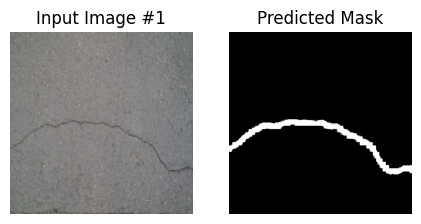

1/1 [==============================] - 0s 26ms/step
Dice Coef: 0.3496098518371582


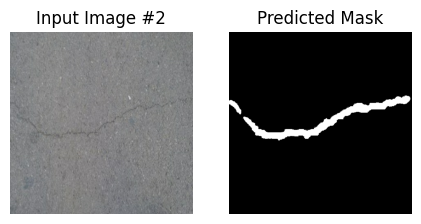

1/1 [==============================] - 0s 27ms/step
Dice Coef: 0.5226876735687256


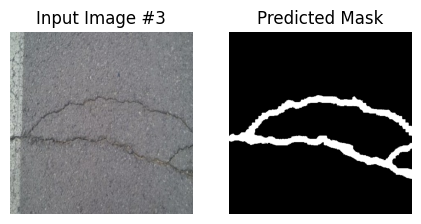

1/1 [==============================] - 0s 24ms/step
Dice Coef: 0.38161715865135193


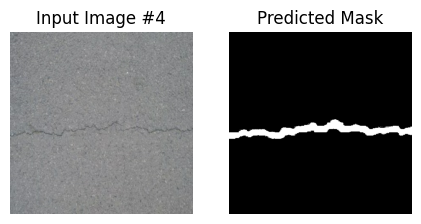

1/1 [==============================] - 0s 30ms/step
Dice Coef: 0.5090137124061584


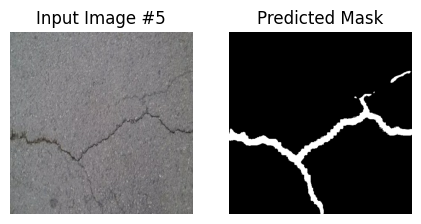

1/1 [==============================] - 0s 24ms/step
Dice Coef: 0.3665347695350647


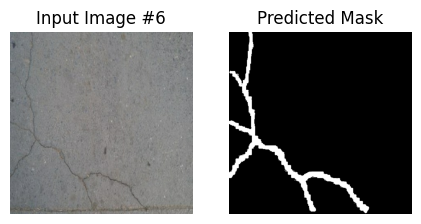

1/1 [==============================] - 0s 27ms/step
Dice Coef: 0.42803314328193665


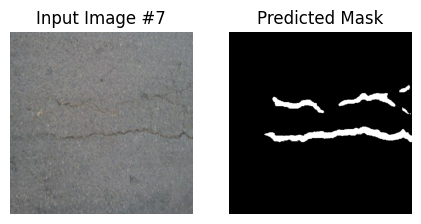

1/1 [==============================] - 0s 31ms/step
Dice Coef: 0.3229687213897705


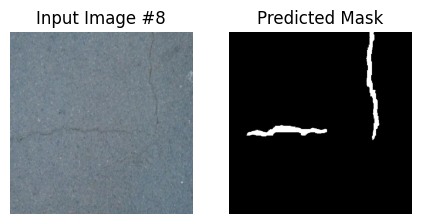

1/1 [==============================] - 0s 26ms/step
Dice Coef: 0.33076176047325134


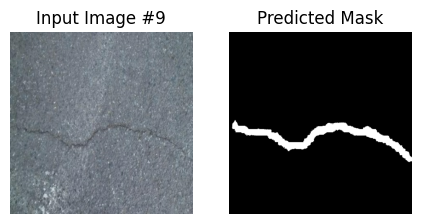

In [6]:
model = tf.keras.models.load_model(
    "no_stopping_unet_autoencoder.keras",
    custom_objects={"dice_coef": dice_coef, "dice_loss": dice_loss}
)

def show_pred(idx):
    img_path  = final_test_imgs[idx]
    mask_path = final_test_masks[idx]

    img, true_mask = load_image_mask(img_path, mask_path)

    pred_mask = model.predict(tf.expand_dims(img, 0))[0]

    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    all_ones = np.ones_like(true_mask)
    print(f"Dice Coef: {dice_coef(tf.expand_dims(pred_mask,0), tf.expand_dims(true_mask,0)).numpy()}")

    plt.figure(figsize=(8,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(f"Input Image #{idx}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(pred_mask[:,:,0], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


for idx in range(1,10):
    show_pred(idx)